In [ ]:
# """
# ## Deep Learning Seminar: CNN Architectures - VGG vs ResNet on CIFAR-100
# Revised Version with Architecture Fixes
# """

### 1. Setup: Imports and Device Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import copy
import time
import os
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


### 2. Data Loading and Preprocessing (CIFAR-100)

In [ ]:
# Define transformations
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# ADD TRANSFORMS TRAIN: Random Crop
transform_train = transforms.Compose([
    <YOUR_CODE_HERE>
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### 3. Model Preparation (Critical Fixes for ResNet)

In [ ]:
def get_vgg16_for_cifar100(pretrained=True):
    # 1. Create VGG16 model with pretrained weights (optionally)
    # Use models.vgg16 and models.VGG16_Weights.IMAGENET1K_V1 or None depending on "pretrained"
    <YOUR_CODE_HERE>

    # Modify classifier
    # 2. Set first maxpool layer to Identify
    <YOUR_CODE_HERE>
    # 3. Adjust number of classes
    <YOUR_CODE_HERE>

    return model

def get_resnet18_for_cifar100(pretrained=True):
    # 1. Create ResNet18 model with pretrained weights (optionally)
    # Use models.resnet18 and models.ResNet18_Weights.IMAGENET1K_V1 or None depending on "pretrained"
    <YOUR_CODE_HERE>

    # Critical architecture modifications for CIFAR
    # 1. Change first conv layer from 7x7 to 3x3 with padding=1, stride=1, and 3 input and 64 output channels
    <YOUR_CODE_HERE>
    # 2. Nullify first maxpool layer
    <YOUR_CODE_HERE>

    # 3. Modify final layer
    <YOUR_CODE_HERE>
    return model

### 4. Training Configuration (Different Hyperparameters per Model)

In [ ]:
# Training parameters
NUM_EPOCHS = 15  # Increased from 15 to allow ResNet to converge
CRITERION = nn.CrossEntropyLoss()

# ResNet-specific parameters
RESNET_LR = 0.1
RESNET_MOMENTUM = 0.9
RESNET_WD = 5e-4

# VGG-specific parameters
VGG_LR = 0.01
VGG_MOMENTUM = 0.9
VGG_WD = 1e-4

### 5. Revised Training Loop with Cosine Annealing

In [ ]:
def train_model(model, optimizer, scheduler, train_loader, test_loader, device, model_name):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Training {model_name}', leave=False):
            # 1. Put inputs and labels to device
            <YOUR_CODE_HERE>

            # 2. Set gradients to zero
            <YOUR_CODE_HERE>
            # 3. Compute model's output (forward pass)
            <YOUR_CODE_HERE>
            # 4. Compute loss
            <YOUR_CODE_HERE>
            # 5. Make backward (backward pass)
            <YOUR_CODE_HERE>
            # 6. Update model parameters
            <YOUR_CODE_HERE>

            running_loss += loss.item() * inputs.size(0)
            # 7. Compute class predictions
            <YOUR_CODE_HERE>
            total += labels.size(0)
            # 8. Count number of correct predictions
            <YOUR_CODE_HERE>

        if scheduler:
            scheduler.step()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Testing {model_name}', leave=False):
                # 9. Put inputs and labels to device
                <YOUR_CODE_HERE>
                # 10. Compute model's output
                <YOUR_CODE_HERE>
                # 11. Compute loss
                <YOUR_CODE_HERE>

                test_loss += loss.item() * inputs.size(0)
                # 12. Compute class predictions
                <YOUR_CODE_HERE>
                test_total += labels.size(0)
                # 13. Count number of correct predictions
                <YOUR_CODE_HERE>

        test_epoch_loss = test_loss / test_total
        test_epoch_acc = test_correct / test_total
        history['test_loss'].append(test_epoch_loss)
        history['test_acc'].append(test_epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}')

        # Save best model
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"New best accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### 6. Main Training Execution

In [ ]:
# Initialize models
resnet18 = get_resnet18_for_cifar100(pretrained=True).to(device)
vgg16 = get_vgg16_for_cifar100(pretrained=True).to(device)

# ResNet optimizer/scheduler
optimizer_resnet = optim.SGD(resnet18.parameters(), lr=RESNET_LR,
                            momentum=RESNET_MOMENTUM, weight_decay=RESNET_WD)
scheduler_resnet = lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=NUM_EPOCHS)

# VGG optimizer/scheduler
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=VGG_LR,
                         momentum=VGG_MOMENTUM, weight_decay=VGG_WD)
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=25, gamma=<YOUR_CODE_HERE>)

# Train both models
print("Training ResNet-18...")
resnet18, resnet_history = train_model(resnet18, optimizer_resnet, scheduler_resnet,
                                      train_loader, test_loader, device, "ResNet-18")

print("\nTraining VGG-16...")
vgg16, vgg_history = train_model(vgg16, optimizer_vgg, scheduler_vgg,
                                train_loader, test_loader, device, "VGG-16")

### 7. Training Curves Visualization

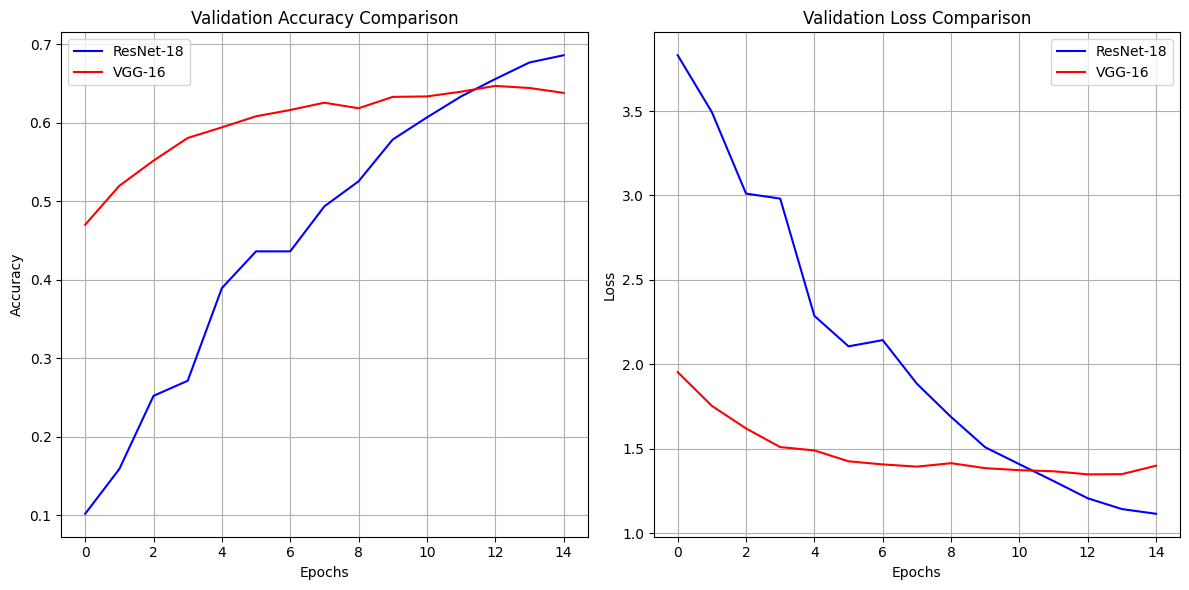

In [ ]:
# %%
def plot_comparison(resnet_history, vgg_history):
    plt.figure(figsize=(12, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(resnet_history['test_acc'], label='ResNet-18', color='blue')
    plt.plot(vgg_history['test_acc'], label='VGG-16', color='red')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(resnet_history['test_loss'], label='ResNet-18', color='blue')
    plt.plot(vgg_history['test_loss'], label='VGG-16', color='red')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comparison(resnet_history, vgg_history)

### 8. PCA Analysis of Learned Features

In [ ]:
def extract_features(model, dataloader, device):
    features = []
    labels_list = []
    handle = None

    # Register hook for ResNet
    if isinstance(model, models.ResNet):
        handle = model.fc.register_forward_hook(
            lambda module, input, output: features.append(input[0].detach().cpu().numpy()))
    # Register hook for VGG
    elif isinstance(model, models.VGG):
        handle = model.classifier[6].register_forward_hook(
            lambda module, input, output: features.append(input[0].detach().cpu().numpy()))

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Extracting features'):
            inputs = inputs.to(device)
            _ = model(inputs)
            labels_list.append(labels.numpy())

    handle.remove()
    return np.concatenate(features), np.concatenate(labels_list)

def plot_pca(features, labels, title):
    # Standardize and PCA
    features = StandardScaler().fit_transform(features)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1],
                c=labels, cmap='tab20', alpha=0.6, s=10)
    plt.title(f'{title}\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Class')
    plt.show()

# Extract features
resnet_features, resnet_labels = extract_features(resnet18, test_loader, device)
vgg_features, vgg_labels = extract_features(vgg16, test_loader, device)

# Plot PCA
plot_pca(resnet_features, resnet_labels, 'ResNet-18 Feature Space')
plot_pca(vgg_features, vgg_labels, 'VGG-16 Feature Space')

Note that the explained variance is quite low due to the limitations of PCA in a multidimensional environment as a linear method.

It is also possible to use tSNE for the same purpose:

In [ ]:
def plot_tSNE(features, labels, title):
    # Standardize and tSNE
    features = StandardScaler().fit_transform(features)
    tsne = TSNE(n_components=2)
    components = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    plt.scatter(components[:, 0], components[:, 1],
                c=labels, cmap='tab20', alpha=0.6, s=10)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Class')
    plt.show()

# Plot tSNE
plot_tSNE(resnet_features, resnet_labels, 'ResNet-18 Feature Space')
plot_tSNE(vgg_features, vgg_labels, 'VGG-16 Feature Space')

###Question: How does a good feature space look like? How does a bad feature space look like? What happens to the features when a classifier does its job?

### 9. Feature Map Dimension Analysis

In [ ]:
def analyze_dimensions(model, model_name):
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    print(f"\n{model_name} Feature Map Dimensions:")

    if isinstance(model, models.ResNet):
        x = model.conv1(dummy_input)
        print(f"After conv1: {x.shape}")
        x = model.bn1(x)
        x = model.relu(x)
        print(f"After bn1+relu: {x.shape}")
        x = model.layer1(x)
        print(f"After layer1: {x.shape}") # Residual layer block 1
        x = model.layer2(x)
        print(f"After layer2: {x.shape}") # Residual layer block 2
        x = model.layer3(x)
        print(f"After layer3: {x.shape}") # Residual layer block 3
        x = model.layer4(x)
        print(f"After layer4: {x.shape}") # Residual layer block 4, final before FC Layer

    elif isinstance(model, models.VGG):
        for idx, layer in enumerate(model.features):
            dummy_input = layer(dummy_input)
            if isinstance(layer, nn.MaxPool2d):
                print(f"After pool{idx//4}: {dummy_input.shape}")

analyze_dimensions(resnet18, "ResNet-18")
analyze_dimensions(vgg16, "VGG-16")

Why ResNet Outperforms VGG on CIFAR:

Model	Final Feature Map Size	Spatial Info Retention
VGG-16	1x1	❌ (All spatial info lost)
ResNet-18	4x4	✅ (Preserves some spatial structure)
For small images, losing spatial resolution too early degrades accuracy.

### 10. Gradient Flow Analysis
Let's show what happens to the gradient across the first, final and middle layers of both networks.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


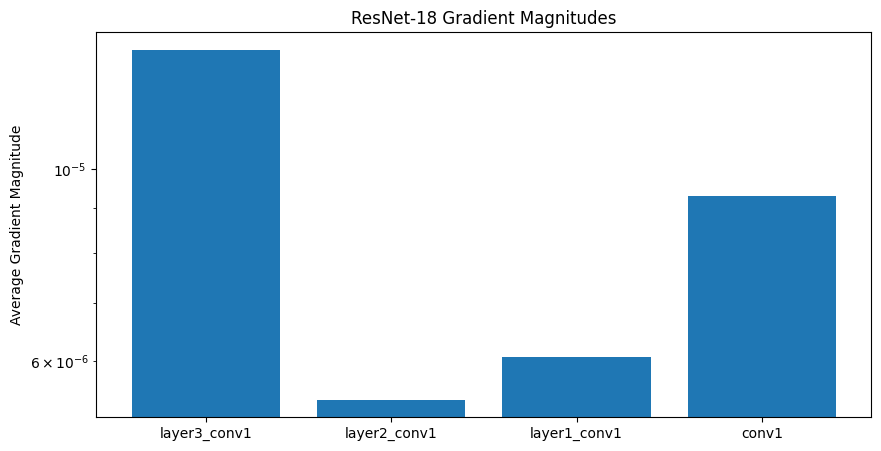

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


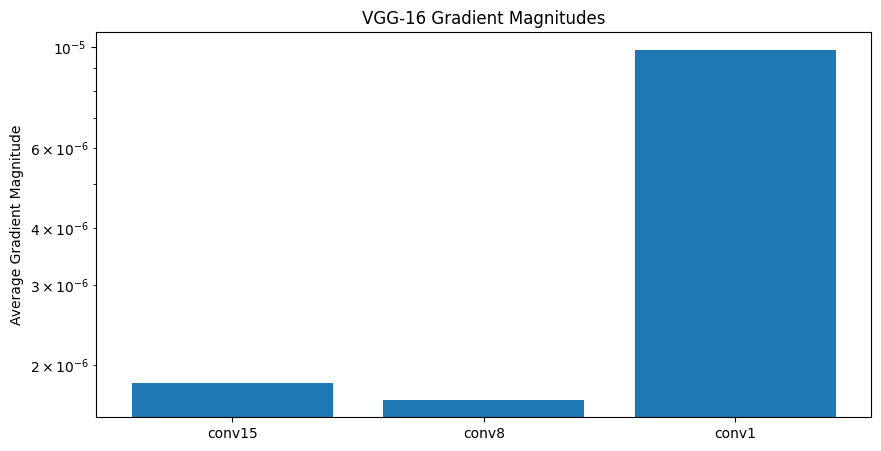

In [ ]:
def analyze_gradients(model, model_name):
    # Get sample batch
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Register hooks
    gradients = {}
    def save_grad(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].abs().mean().item()
        return hook

    if isinstance(model, models.ResNet):
        hooks = [
            model.conv1.register_backward_hook(save_grad('conv1')),
            model.layer1[0].conv1.register_backward_hook(save_grad('layer1_conv1')),
            model.layer2[0].conv1.register_backward_hook(save_grad('layer2_conv1')),
            model.layer3[0].conv1.register_backward_hook(save_grad('layer3_conv1')),
        ]
    elif isinstance(model, models.VGG):
        hooks = [
            model.features[0].register_backward_hook(save_grad('conv1')),
            model.features[7].register_backward_hook(save_grad('conv8')),
            model.features[14].register_backward_hook(save_grad('conv15')),
        ]

    # Forward + backward
    model.zero_grad()
    outputs = model(inputs)
    loss = CRITERION(outputs, labels)
    loss.backward()

    # Remove hooks
    for h in hooks:
        h.remove()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), list(gradients.values()), tick_label=list(gradients.keys()))
    plt.title(f'{model_name} Gradient Magnitudes')
    plt.ylabel('Average Gradient Magnitude')
    plt.yscale('log')
    plt.show()

analyze_gradients(resnet18, "ResNet-18")
analyze_gradients(vgg16, "VGG-16")


###As you can see, the gradient drops in VGG by layer 8 and doesn't recover by the final layer

###Conversely, gradient in ResNet recovers due to the skip connections

### 11. Final Performance Summary


Final Results:
Model           | Best Val Acc | Final Val Acc
----------------------------------------
ResNet-18       | 0.7400       | 0.7400
VGG-16          | 0.6541       | 0.6461


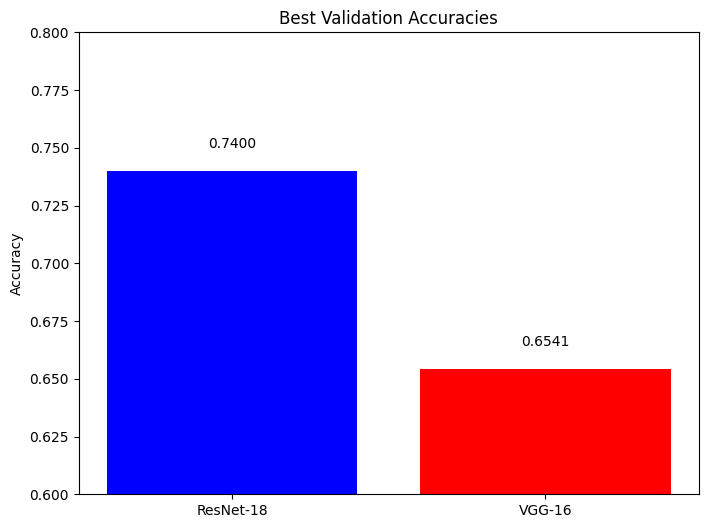

In [ ]:
def print_final_results(resnet_history, vgg_history):
    print("\nFinal Results:")
    print(f"{'Model':<15} | {'Best Val Acc':<12} | {'Final Val Acc':<12}")
    print("-" * 40)
    print(f"{'ResNet-18':<15} | {max(resnet_history['test_acc']):.4f}       | {resnet_history['test_acc'][-1]:.4f}")
    print(f"{'VGG-16':<15} | {max(vgg_history['test_acc']):.4f}       | {vgg_history['test_acc'][-1]:.4f}")

    plt.figure(figsize=(8, 6))
    models = ['ResNet-18', 'VGG-16']
    accuracies = [max(resnet_history['test_acc']), max(vgg_history['test_acc'])]
    plt.bar(models, accuracies, color=['blue', 'red'])
    plt.title('Best Validation Accuracies')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 0.8)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

print_final_results(resnet_history, vgg_history)

###Summary: By better preserving spatial information and gradients, ResNet-18 outperforms VGG-16 at similar depth and epoch number.

Additional tasks

Now you have the code to load and train the model and analyze its training behavior. Using this code, complete the following tasks:

1. Explore the influence of batch size on the model training. Which values correspond to better performance? Is there a difference in the optimal batch size for VGG and ResNet models? Do you see difference in the representation spaces for different values of batch size?
2. Make an experiment to estimate the influence of batch normalization on the model performance. Use VGG models with and without batch normalization and compare their quality. Feel free to use VGG models of various sizes. Which variant achieves the best performance? Is the outcome the same for models of different sizes? Does batch norm significantly alter the representation space?